In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.13
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.2.3
torch       : 2.6.0+cu124
transformers: 4.52.4



In [5]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


2025-09-06 13:52:42.635305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757166762.824311      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757166762.878255      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Print the shape of the train and test splits
print(f"Train shape: {len(dataset['train'])}")
print(f"Test shape: {len(dataset['test'])}")


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train shape: 25000
Test shape: 25000


In [7]:
from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Convert train split to pandas DataFrame if you want
import pandas as pd
df_train = pd.DataFrame(dataset['train'])

# View first 5 rows
df_train.head()


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [9]:
from datasets import load_dataset
import pandas as pd

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Convert train split to pandas DataFrame
df_train = pd.DataFrame(dataset['train'])

# View first 5 rows
print(df_train.head())

# Dataset info
print(df_train.info())

# First review text
print(df_train['text'][0])

# Function to ensure numeric sentiment
def to_sentiment(label):
    return int(label)  # label is already 0 (negative) / 1 (positive)

# Apply function to df_train
df_train['sentiment_score'] = df_train['label'].apply(to_sentiment)

# Check
print(df_train.head())


                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /

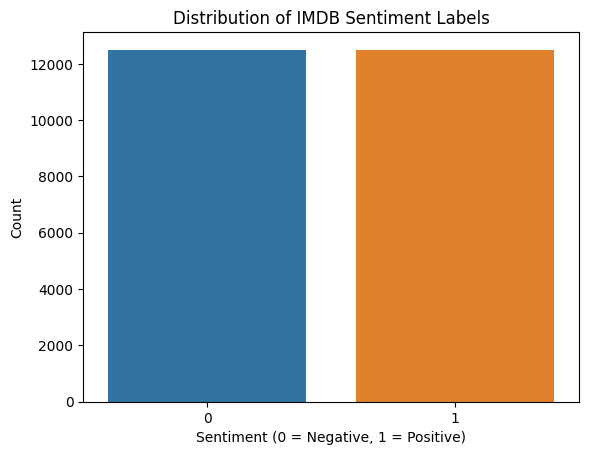

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of sentiment labels
sns.countplot(x='label', data=df_train)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.title('Distribution of IMDB Sentiment Labels')
plt.show()


In [11]:
from transformers import BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding='max_length',         # Use this instead of pad_to_max_length
    return_attention_mask=True,
    return_tensors='pt',          # Return PyTorch tensors
    truncation=True
)

# Check the keys in the encoded output
print(encoding.keys())


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dict_keys(['input_ids', 'attention_mask'])


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


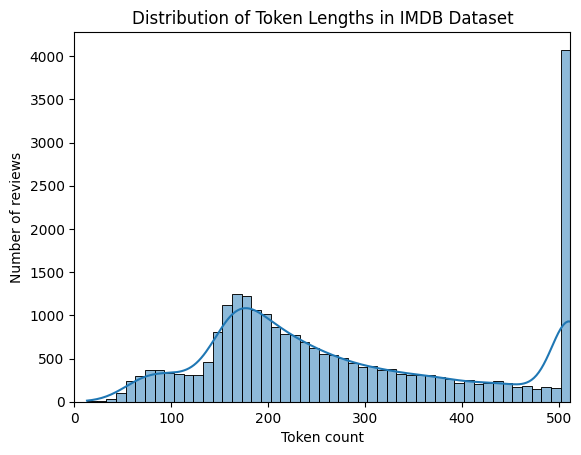

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Collect token lengths
token_lens = []

for txt in df_train['text']:  # Hugging Face dataset column
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

# Plot distribution
sns.histplot(token_lens, bins=50, kde=True)
plt.xlim([0, 512])
plt.xlabel('Token count')
plt.ylabel('Number of reviews')
plt.title('Distribution of Token Lengths in IMDB Dataset')
plt.show()

# Set max length for padding/truncation
MAX_LEN = 400


In [13]:
from torch.utils.data import Dataset
import torch

class MovieReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',      # Updated
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [14]:
RANDOM_SEED = 42
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset
df_train, df_test = train_test_split(df_train, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# Check shapes
print(df_train.shape, df_val.shape, df_test.shape)

# Function to create DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = MovieReviewDataset(
        reviews=df['text'].to_numpy(),          # Hugging Face column name
        targets=df['sentiment_score'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

# Example usage
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


(17500, 3) (3750, 3) (3750, 3)


In [15]:
data = next(iter(train_data_loader))
print(data.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [16]:
print(data['input_ids'].shape)        # torch.Size([16, 400])
print(data['attention_mask'].shape)   # torch.Size([16, 400])
print(data['targets'].shape)          # torch.Size([16])

torch.Size([16, 400])
torch.Size([16, 400])
torch.Size([16])


In [17]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [18]:
from transformers import BertModel

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

outputs = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)

last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output

print(last_hidden_state.shape)  # e.g., torch.Size([1, 32, 768])
print(pooled_output.shape)      # e.g., torch.Size([1, 768])


torch.Size([1, 32, 768])
torch.Size([1, 768])


In [19]:
bert_model.config.hidden_size

768

In [20]:
pooled_output.shape

torch.Size([1, 768])

In [21]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output  # Use pooler_output attribute
        output = self.drop(pooled_output)
        return self.out(output)

In [22]:
class_names = ['negative', 'positive']
len(class_names)

2

In [23]:
import torch

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Instantiate model
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Move a batch from DataLoader to device
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)        # batch_size x sequence_length
print(attention_mask.shape)   # batch_size x sequence_length


cuda
torch.Size([16, 400])
torch.Size([16, 400])


In [24]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5988, 0.4012],
        [0.4825, 0.5175],
        [0.5584, 0.4416],
        [0.5253, 0.4747],
        [0.4473, 0.5527],
        [0.5645, 0.4355],
        [0.4731, 0.5269],
        [0.4908, 0.5092],
        [0.6504, 0.3496],
        [0.7729, 0.2271],
        [0.5745, 0.4255],
        [0.4571, 0.5429],
        [0.5970, 0.4030],
        [0.6839, 0.3161],
        [0.7130, 0.2870],
        [0.4190, 0.5810]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [25]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

EPOCHS = 10

# Optimizer using torch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)  # no correct_bias

# Total steps for scheduler
total_steps = len(train_data_loader) * EPOCHS

# Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


In [26]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [27]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.2890220077723687 accuracy 0.8848571428571428
Val   loss 0.2696066695265472 accuracy 0.9168000000000001

Epoch 2/10
----------
Train loss 0.16537682912889204 accuracy 0.9502285714285714
Val   loss 0.32370163617814157 accuracy 0.9237333333333334

Epoch 3/10
----------
Train loss 0.09322745714935098 accuracy 0.9774857142857143
Val   loss 0.3981354103361732 accuracy 0.9192

Epoch 4/10
----------
Train loss 0.059147840980539344 accuracy 0.9870857142857142
Val   loss 0.38652936919106845 accuracy 0.9258666666666667

Epoch 5/10
----------
Train loss 0.04038449243148742 accuracy 0.9915999999999999
Val   loss 0.46461875193642127 accuracy 0.9232

Epoch 6/10
----------
Train loss 0.02416884281588179 accuracy 0.9953714285714286
Val   loss 0.485445890559826 accuracy 0.9258666666666667

Epoch 7/10
----------
Train loss 0.015980379286585984 accuracy 0.9969142857142856
Val   loss 0.5307181611472612 accuracy 0.9309333333333334

Epoch 8/10
----------
Train loss 0.014739

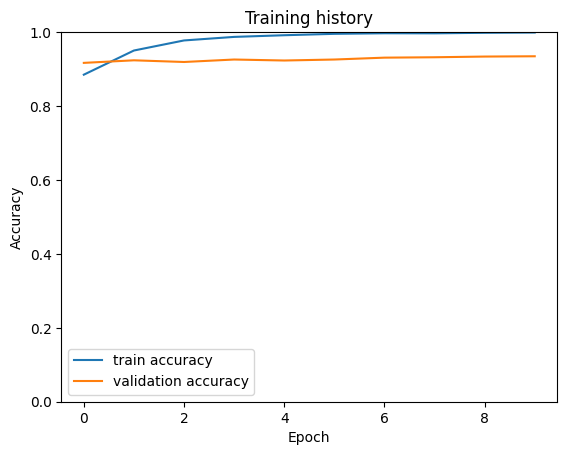

In [29]:
train_acc = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['train_acc']]
val_acc   = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.show()

In [30]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9237333333333334

In [31]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [32]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [33]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.93      0.92      1848
    positive       0.93      0.92      0.92      1902

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



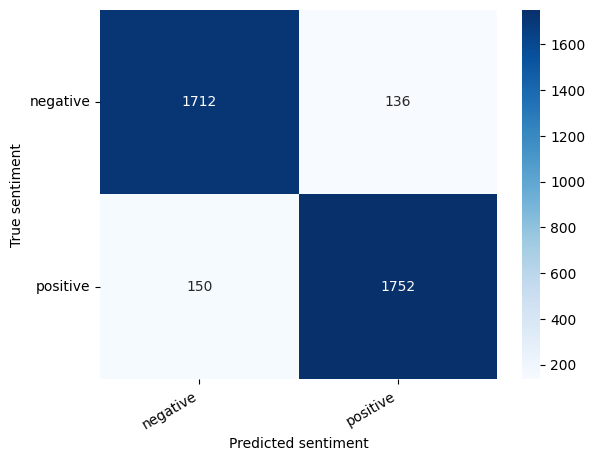

In [34]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [35]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [36]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Q.E.D. was a brilliant TV series and it truly was one of the very few
worth scheduling for! I suspect that in this era of TIVO and recording
devices that it would fare much better than it did in 1982. I am
eagerly awaiting its availability on DVD!<br /><br />While it is true
that it has some in common with other television shows like The Wild,
Wild West, The Bearcats and The Adventures of Brisco County, Jr., all
of which I am a huge fan of,Q.E.D. had a much more intellectual
quality to it. It did not suffer for that, however - the dialog was
witty and the action was high. The show ran in the UK as Mastermind,
and it did have something of the BBC feel to it, but with better
production values than BBC typically had in that era.<br /><br />I was
a nineteen year old lad when this series ran initially, and had much
too much to do in my life to make time for television. I remember my
dear mother, however, calling me to remind me that Q.E.D. was on, and
we would sit on the phone and watch it 

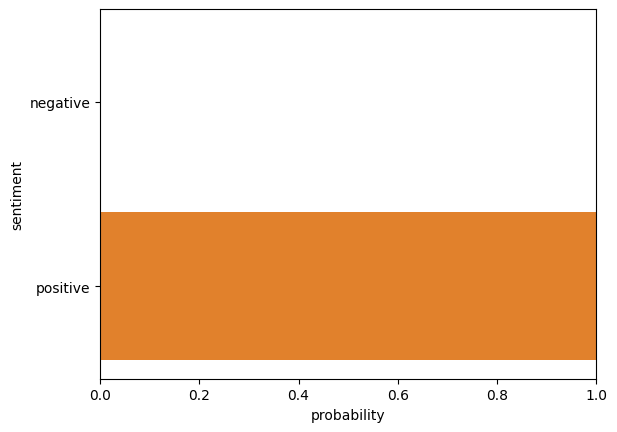

In [37]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);